In [1]:
import requests
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset, load_from_disk
import chess

In [ ]:
dset = load_dataset("Lichess/chess-puzzles", split="train")
new_dset = dset.select(range(3000))
new_dset.save_to_disk("Lichess/chess-puzzles-3000")

In [110]:
new_dset = load_from_disk("Lichess/chess-puzzles-3000")

In [111]:
def get_game_id(game_url):
    """
    extract the game id from the lichess url
    https://lichess.org/l6AejDMO#105
    https://lichess.org/787zsVup/black#48
    """
    return game_url.split("/")[3].split("#")[0]

In [112]:
def get_game_pgn(game_ids) -> requests.Response:
    url = f"https://lichess.org/api/games/export/_ids"
    params = {"pgnInJson": "true"}
    headers = {"Accept": "application/x-ndjson"}
    response = requests.post(url, data=",".join(game_ids), params=params, headers=headers)
    return response

In [113]:
game_ids = [get_game_id(x) for x in new_dset["GameUrl"]]
game_data = []

CHUNK_SIZE = 300
for i in tqdm(range(0, len(game_ids), CHUNK_SIZE)):
    chunk = game_ids[i:i+CHUNK_SIZE]
    x = get_game_pgn(chunk)
    game_data.extend(x.text.splitlines())

with open("game_data.jsonl", "w") as f:
    for line in game_data:
        f.write(line + "\n")

  0%|          | 0/10 [00:00<?, ?it/s]

In [121]:
id_to_game_data = {json.loads(line)["id"]: json.loads(line) for line in game_data}

In [115]:
def uci_to_san_from_fen(example):
    """Convert UCI moves to SAN notation from a given FEN position"""
    board = chess.Board(example["FEN"])
    san_moves = []
    
    for uci in example["Moves"].split():
        move = chess.Move.from_uci(uci)
        san_moves.append(board.san(move))
        board.push(move)
    
    return {"Puzzle_Moves_SAN": " ".join(san_moves)}

In [116]:
new_dset = new_dset.map(uci_to_san_from_fen)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [128]:
def add_full_moves(example):
    """Add full moves to the example"""

    game_id = get_game_id(example["GameUrl"])
    san_moves = id_to_game_data[game_id]["moves"]
    
    return {"GameId": game_id, "Full_Moves_SAN": san_moves}

In [129]:
new_dset = new_dset.map(add_full_moves)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
new_dset[0]

{'PuzzleId': '00008',
 'FEN': 'r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - - 0 24',
 'Moves': 'f2g3 e6e7 b2b1 b3c1 b1c1 h6c1',
 'Rating': 1807,
 'RatingDeviation': 75,
 'Popularity': 95,
 'NbPlays': 8585,
 'Themes': ['crushing', 'hangingPiece', 'long', 'middlegame'],
 'OpeningTags': None,
 'PuzzleUrl': 'https://lichess.org/training/00008',
 'GameUrl': 'https://lichess.org/787zsVup/black#48',
 'Puzzle_Moves_SAN': 'Bxg3 Rxe7 Qb1+ Nc1 Qxc1+ Qxc1',
 'GameId': '787zsVup',
 'Full_Moves_SAN': 'e4 c6 f4 d5 exd5 cxd5 Nf3 Nc6 d3 Nf6 Be2 Qc7 O-O e5 fxe5 Nxe5 Nxe5 Qxe5 Bf4 Qxb2 Nd2 Bc5+ Kh1 O-O Nb3 Bb6 Bd6 Rd8 Be7 Rd7 Bxf6 gxf6 Rf3 Rc7 Rg3+ Kh8 Bh5 Bf5 Bxf7 Rxf7 Qh5 Be6 Re1 Re7 Qh6 Bf2 Rxe6 Bxg3 Rxe7 Qb1+ Nc1 Rg8 Qxh7#'}

In [136]:
new_dset.save_to_disk("Lichess/chess-puzzles-3000-full-moves")

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [141]:
x = new_dset[0]
move_number = int(x["FEN"].split()[-1])
x["Full_Moves_SAN"].split()[move_number * 2 - 1:]

['Bxg3', 'Rxe7', 'Qb1+', 'Nc1', 'Rg8', 'Qxh7#']

# Bucketize

In [4]:
new_dset = load_from_disk("../data/Lichess/chess-puzzles-3000-full-moves")

(array([156., 314., 548., 473., 442., 415., 318., 212.,  94.,  28.]),
 array([ 399. ,  657.9,  916.8, 1175.7, 1434.6, 1693.5, 1952.4, 2211.3,
        2470.2, 2729.1, 2988. ]),
 <BarContainer object of 10 artists>)

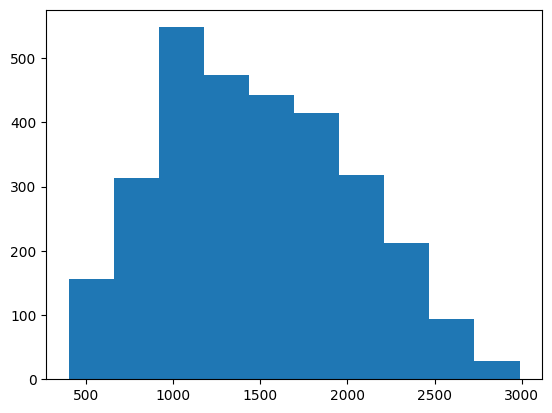

In [8]:
plt.hist(new_dset["Rating"])

Minimum samples available in any bin: 64
Sampling 50 puzzles from each bin


/tmp/ipykernel_3535997/3110669041.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('bin').apply(


Original dataset size: 3000
Sampled dataset size: 600


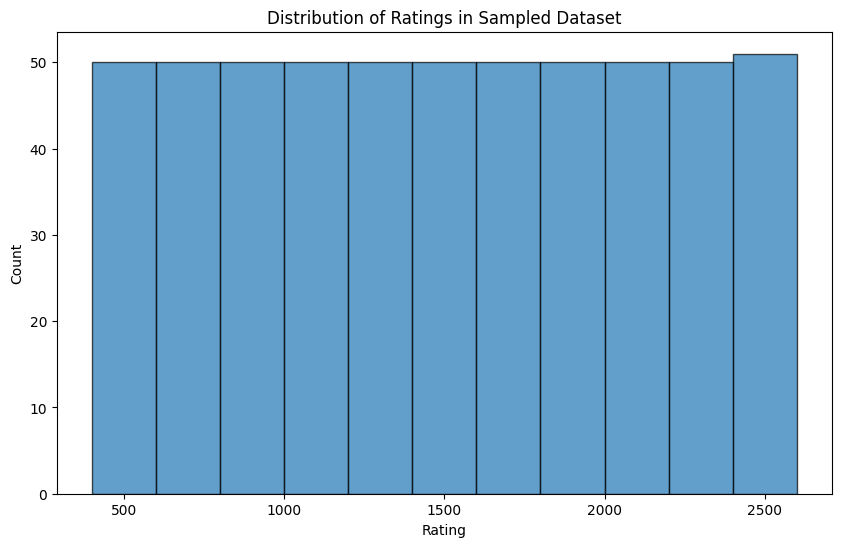

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

In [12]:
import numpy as np
import pandas as pd
from datasets import Dataset

# Get the rating bins (200-wide buckets from 400 to 2800)
ratings = np.array(new_dset["Rating"])
bins = np.arange(400, 2800, 200)

# Get the bin indices for each rating
bin_indices = np.digitize(ratings, bins)

# Convert to pandas DataFrame for easier manipulation
df = new_dset.to_pandas()
df['bin'] = bin_indices

# Filter out ratings outside our bin range (below 400 or above 2800)
df = df[(df['bin'] > 0) & (df['bin'] <= len(bins))]

# Sample an equal number from each bin
# First, find the minimum count across all bins to ensure we can sample equally
min_samples_per_bin = df.groupby('bin').size().min()
print(f"Minimum samples available in any bin: {min_samples_per_bin}")

# Set the number of samples per bin (adjust as needed)
samples_per_bin = min(50, min_samples_per_bin)
print(f"Sampling {samples_per_bin} puzzles from each bin")

# Sample from each bin
sampled_df = df.groupby('bin').apply(
    lambda x: x.sample(n=samples_per_bin, random_state=42)
).reset_index(drop=True)

# Remove the temporary 'bin' column
sampled_df = sampled_df.drop('bin', axis=1)

# Convert back to Hugging Face dataset
sampled_dset = Dataset.from_pandas(sampled_df)

print(f"Original dataset size: {len(new_dset)}")
print(f"Sampled dataset size: {len(sampled_dset)}")

# Show the distribution of ratings in the sampled dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(sampled_dset["Rating"], bins=bins, alpha=0.7, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Sampled Dataset')
plt.show()

n = len(sampled_dset)
# Save the sampled dataset
sampled_dset.save_to_disk(f"../data/Lichess/chess-puzzles-{n}-full-moves-balanced")